# Initialization
- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [47]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution

					# Nproj <- round(TotN[hr+1]*wt.norm)
					# med.pred <- which(Nproj == max(Nproj))
					# width.pred <- diff(range(which(Nproj > 0)))
					# med.obs <- which(V.hists[,hr] == max(V.hists[,hr]))
					# width.obs <- diff(range(which(N.dist[,hr] > 0)))
					# distorsion <- as.vector((min.obs - min.pred)^2 + 2*(med.pred - med.obs)^2)

					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					#sigma[,hr] <- ((N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))/TotN[hr+1]))^2 # RELATIVE observed value - fitted value
					# mean.size.pred <- sum(volbins*wt.norm)
					# mean.size.obs <-  sum(volbins*V.hists[, hr+1])
					# sd.pred <- sqrt(sum((volbins - mean.size.pred)^2)/length(volbins))
					# sd.obs <- sqrt(sum((volbins - mean.size.obs)^2)/length(volbins))
					# sigma[,hr] <- (mean.size.obs - mean.size.pred)/sqrt(sd.obs/TotN[hr+1] + sd.pred/TotN[hr+1])
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [46]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
            }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [32]:
library(R.matlab)
library(seewave)
df <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/day733320data.mat")
time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) #  fg (instead of volume)
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))

resol <- 10
dt <- resol/60
	ime.interval <- median(diff(as.numeric(colnames(V.hists))))
	ti <- as.numeric(colnames(V.hists))

	# create Light data with 'dt' time interval.
		seq <- NULL
		for(i in 1:(length(ti)-1)){
			s <- seq(ti[i], ti[i+1], length.out=1/dt)
			seq <- c(seq, s)
		}

	ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
	Einterp <- ep$y
	Einterp[Einterp < 0] <- 0


results <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/results.mat")
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
require(DEoptim)

		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

# 1. ORIGINAL model

## 1a. Load Matrix ORIGINAL Model

In [33]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
 		c <- 0
		resp <- conv*(1.35294 * mean(y) + 0.05018) * mean(y)# proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [5]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		c <- params[5]
		d <- params[6]
		resnorm <- opt$optim$bestval


Iteration: 10 bestvalit: 5.895203 bestmemit:    0.213570    0.050352    4.271396  416.249521    3.530595    4.867962
Iteration: 20 bestvalit: 5.438647 bestmemit:    0.213570    0.050352    4.271396  214.351028    2.676386    4.867962
Iteration: 30 bestvalit: 5.008177 bestmemit:    0.172204    0.036087    4.186758  257.062667    0.788687    6.587746
Iteration: 40 bestvalit: 5.002798 bestmemit:    0.172204    0.036087    3.837324  257.062667    1.365138    6.587746
Iteration: 50 bestvalit: 4.979666 bestmemit:    0.167403    0.036691    4.094091  254.717819    4.319756    8.651892
Iteration: 60 bestvalit: 4.979666 bestmemit:    0.167403    0.036691    4.094091  254.717819    2.366011    5.608191
Iteration: 70 bestvalit: 4.977505 bestmemit:    0.168072    0.036777    4.041048  244.131621    1.713047    7.615802
Iteration: 80 bestvalit: 4.975267 bestmemit:    0.167751    0.037211    4.044604  256.391346    3.036342    9.118223
Iteration: 90 bestvalit: 4.975160 bestmemit:    0.165246    0.03

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [34]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		c. <- params[5]
		d. <- params[6]
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.262224 bestmemit:    0.181244    0.050661    3.716259  236.549190    7.296016    0.497951
Iteration: 20 bestvalit: 0.244034 bestmemit:    0.232051    0.043354    3.967395  279.434201   11.911787    1.335344
Iteration: 30 bestvalit: 0.241393 bestmemit:    0.198434    0.028906    4.005468  297.139510    3.992994    1.537334
Iteration: 40 bestvalit: 0.232147 bestmemit:    0.178076    0.032602    3.729259  271.362386    4.313126   12.415576
Iteration: 50 bestvalit: 0.230765 bestmemit:    0.169164    0.031847    3.792923  251.470094    9.809625    4.160761
Iteration: 60 bestvalit: 0.230765 bestmemit:    0.169164    0.031847    3.792923  251.470094   13.432776   10.234388
Iteration: 70 bestvalit: 0.229965 bestmemit:    0.173277    0.032524    3.906634  262.420324   10.515401   12.232275
Iteration: 80 bestvalit: 0.229906 bestmemit:    0.173277    0.032524    3.906634  257.233376   10.515401    7.347488
Iteration: 90 bestvalit: 0.229906 bestmemit:    0.173277    0.03

## 1c. Results

[1] "daily growth rate= 0.72 - 0.72"


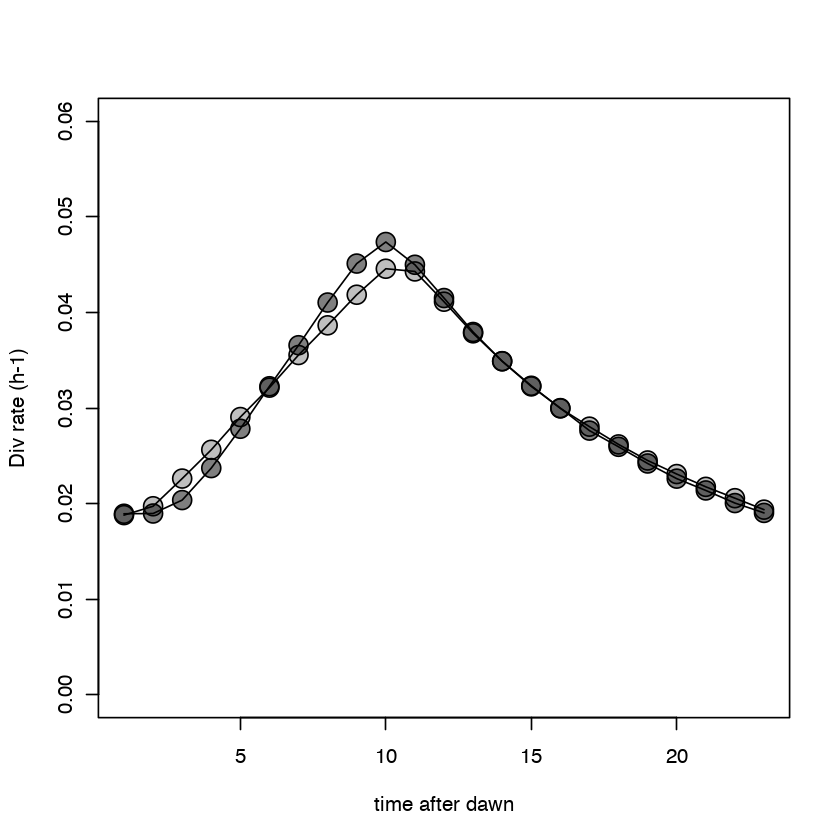

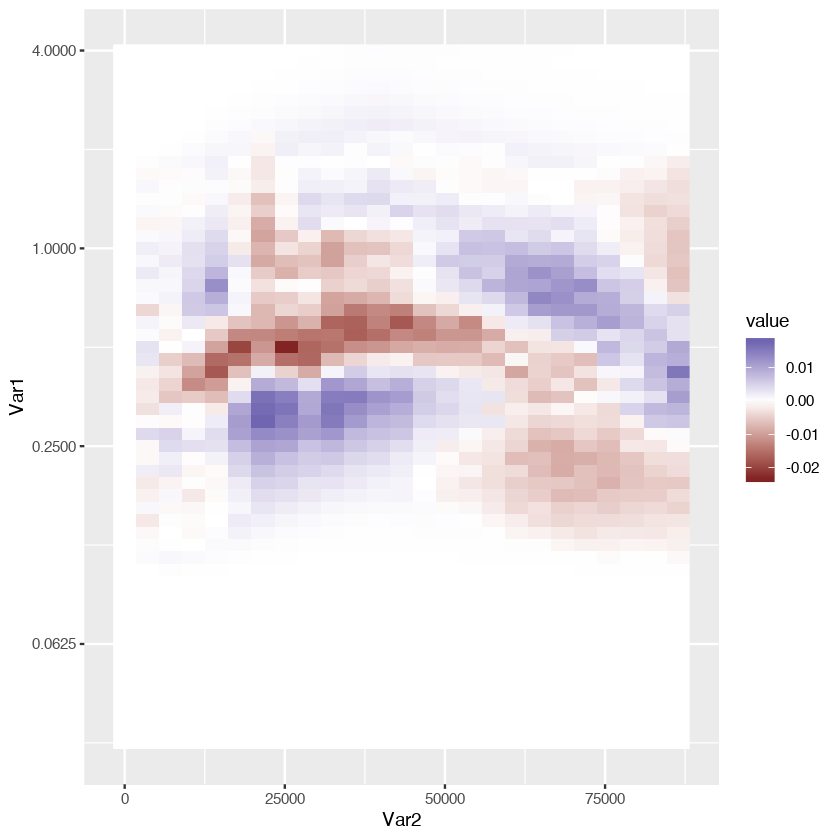

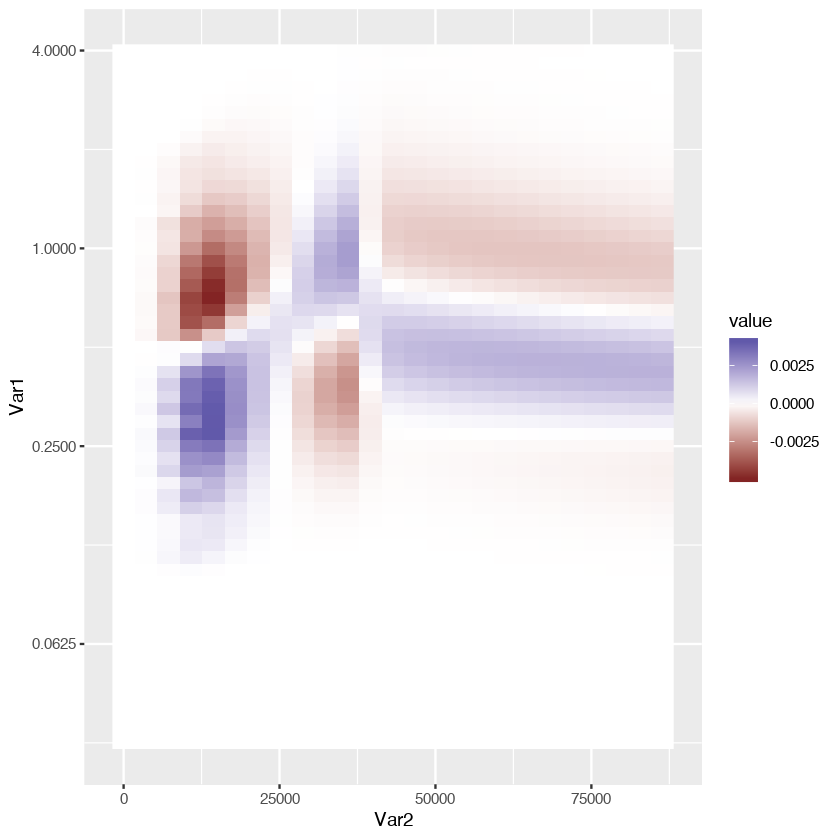

In [36]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
        library(ggplot2)
        library(reshape2)
		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj <- Vproj. <- V.hists
		Nproj <- Nproj. <- N.dist
		mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star,c=c, d=d, resol=resol)
                    Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
					Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
					Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
					mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
								((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
            B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star.,c=c., d=d., resol=resol)
                    Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
					Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
					Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
					mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
								((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
						}
		Nproj <- colSums(Nproj)
		colnames(mu_N) <- colnames(Vproj)
		Nproj. <- colSums(Nproj.)
		colnames(mu_N.) <- colnames(Vproj.)
		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
		d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

		print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2)))

plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))


#ggplot(melt(Vproj), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + viridis::scale_fill_viridis()
ggplot(melt(Vproj-V.hists), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()
ggplot(melt(Vproj.-Vproj), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()


# 2. Model with Respiration


## 2a. Load matrix model

In [48]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
 		# c <- 0
		resp <-  conv * (1.35294 * mean(y) + 0.05018) * mean(y) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			#allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			#allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 2b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [42]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		c2 <- params[5]
		d2 <- params[6]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.990507 bestmemit:    0.075749    0.024486    7.473495  297.862857    4.006372    2.513108
Iteration: 20 bestvalit: 5.101593 bestmemit:    0.102451    0.021356    7.038741  284.792249    4.066654    7.719745
Iteration: 30 bestvalit: 4.902665 bestmemit:    0.114088    0.017332    5.639325  285.305291    3.209451    9.409335
Iteration: 40 bestvalit: 4.769866 bestmemit:    0.145386    0.023807    4.856586  253.802885    1.707018    1.977953
Iteration: 50 bestvalit: 4.757527 bestmemit:    0.135923    0.026085    4.964372  242.037615    1.648070    5.578356
Iteration: 60 bestvalit: 4.751874 bestmemit:    0.145470    0.025828    4.391805  257.574875    1.565637    4.080371
Iteration: 70 bestvalit: 4.736404 bestmemit:    0.140999    0.026514    4.622983  251.656957    1.600127   11.501014
Iteration: 80 bestvalit: 4.736404 bestmemit:    0.140999    0.026514    4.622983  251.656957    1.600127    4.295731
Iteration: 90 bestvalit: 4.734794 bestmemit:    0.143759    0.02

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [50]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		c2. <- params[5]
		d2. <- params[6]
		resnorm2. <- opt$optim$bestval

ERROR: Error in seewave::kl.dist(N.dist[, hr + 1], round(TotN[hr + 1] * wt.norm)): Data do not have to be in dB


## 2c. Results

        par1         par2         par3         par4         par5         par6 
  0.14466481   0.02639003   4.59452439 258.33675716   1.47370700   8.03314196 
[1] "daily growth rate= 0.64 - 0.38"


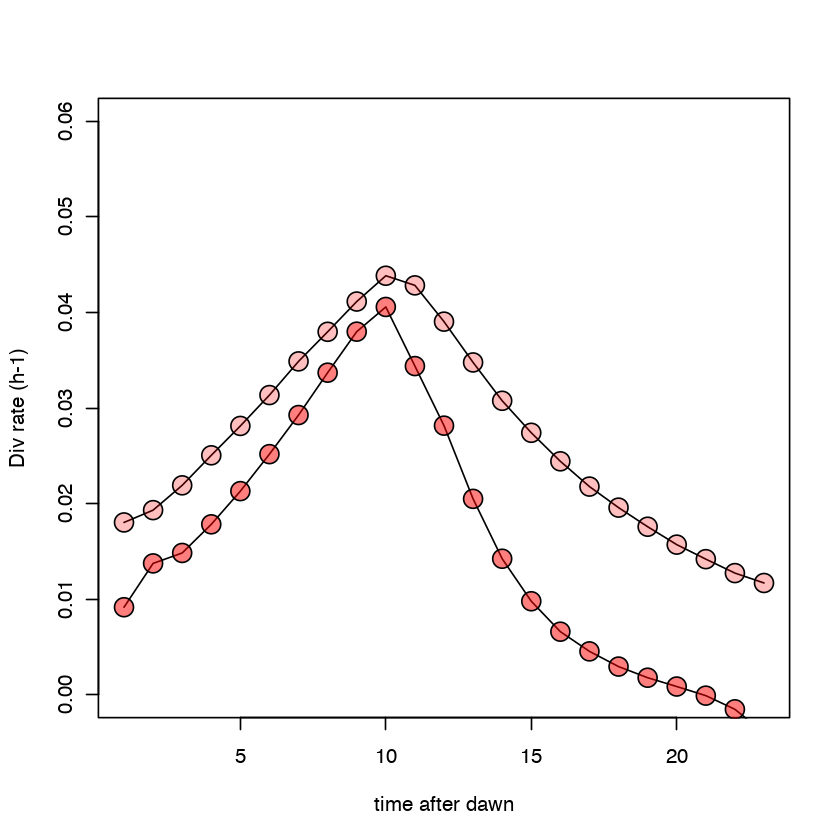

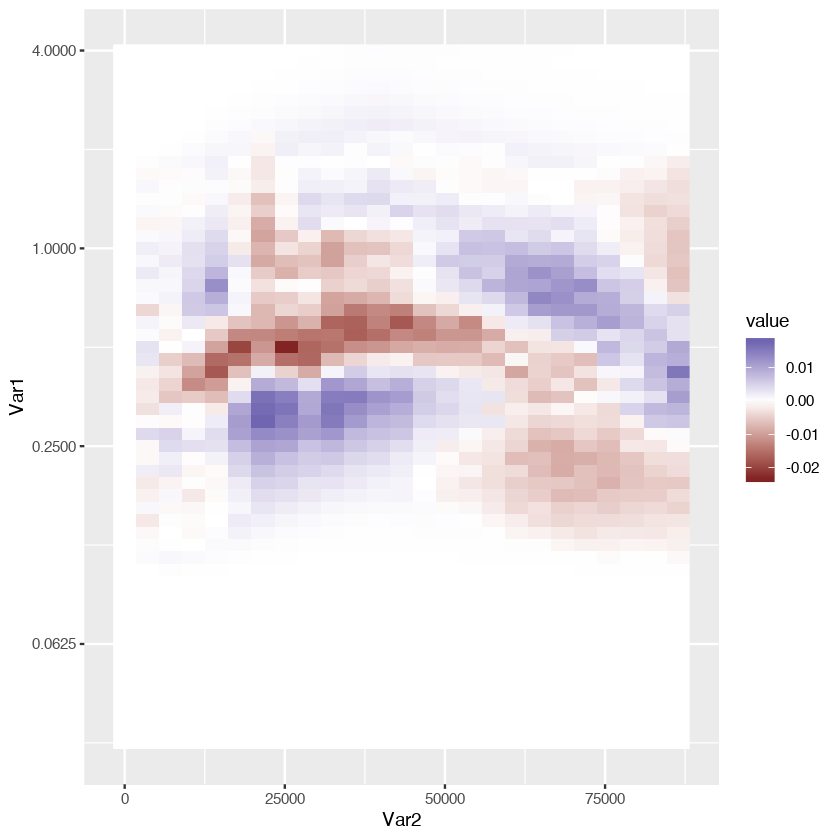

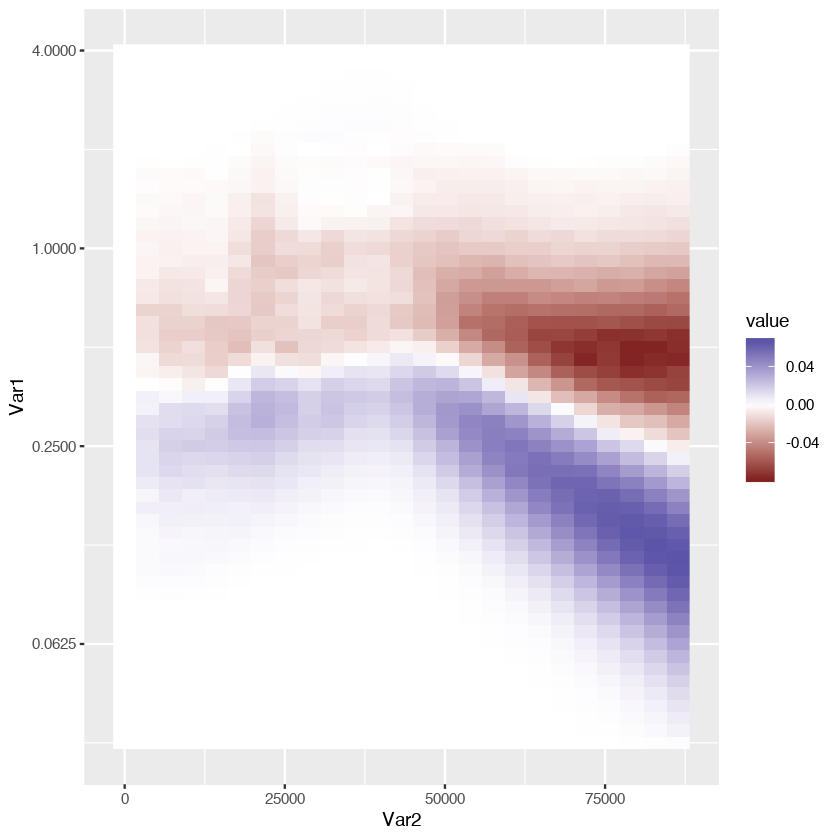

In [45]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
        library(ggplot2)
        library(reshape2)
		print(params)

		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj2 <- Vproj2. <- V.hists
		Nproj2 <- Nproj2. <- N.dist
		mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star,c=c, d=d, resol=resol)
                    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
					Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
					Vproj2[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
					mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
								((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
            B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2.,c=c2., d=d2., resol=resol)
                    Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
					Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
					Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
					mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
								((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						}
		Nproj2 <- colSums(Nproj2)
		colnames(mu_N2) <- colnames(Vproj2)
		Nproj2. <- colSums(Nproj2.)
		colnames(mu_N2.) <- colnames(Vproj2.)
		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
		d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

		print(paste("daily growth rate=",round(d.mu_N2,2),"-",round(d.mu_N2.,2)))

plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))


#ggplot(melt(Vproj), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + viridis::scale_fill_viridis()
ggplot(melt(Vproj2-V.hists), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()
ggplot(melt(Vproj2.-V.hists), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()


# 3 Model with Respiration + Allometric functions

## 3a. Load matrix model

In [51]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
# 		c <- 0
		resp <-  conv*(1.35294 * mean(y) + 0.05018) * mean(y) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
# 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [52]:
	f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		c3 <- params[5]
		d3 <- params[6]
		resnorm3 <- opt$optim$bestval

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [ ]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3. <- params[1]
		dmax3. <- params[2]
		b3. <- params[3]
		E_star3. <- params[4]
		c3. <- params[5]
		d3. <- params[6]
		resnorm3. <- opt$optim$bestval

## 3c. Results

In [ ]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
        library(ggplot2)
        library(reshape2)
		print(params)

		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj3 <- Vproj3. <- V.hists
		Nproj3 <- Nproj3. <- N.dist
		mu_N3 <- mu_N3. <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3,c=c3, d=d3, resol=resol)
                    Nproj3[,hr+1] <- round(B %*% Nproj3[,hr]) # calculate numbers of individuals
					Vproj3[,hr+1] <- B %*% Vproj3[,hr] # calculate the projected size-frequency distribution
					Vproj3[,hr+1] <- Vproj3[,hr+1]/sum(Vproj3[,hr+1]) # normalize distribution so sum = 1
					mu_N3[,hr+1] <- log(sum(Nproj3[,hr+1])/sum(Nproj3[,hr]))/
								((as.numeric(colnames(Nproj3)[hr+1])-as.numeric(colnames(Nproj3)[hr]))/(time.interval))
            		    
            B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3., dmax=dmax3.,b=b3., E_star=E_star3.,c=c3., d=d3., resol=resol)
                    Nproj3.[,hr+1] <- round(B. %*% Nproj3.[,hr]) # calculate numbers of individuals
					Vproj3.[,hr+1] <- B. %*% Vproj3.[,hr] # calculate the projected size-frequency distribution
					Vproj3.[,hr+1] <- Vproj3.[,hr+1]/sum(Vproj3.[,hr+1]) # normalize distribution so sum = 1
					mu_N3.[,hr+1] <- log(sum(Nproj3.[,hr+1])/sum(Nproj3.[,hr]))/
								((as.numeric(colnames(Nproj3.)[hr+1])-as.numeric(colnames(Nproj3.)[hr]))/(time.interval))
						}
		Nproj3 <- colSums(Nproj3)
		colnames(mu_N3) <- colnames(Vproj3)
		Nproj3. <- colSums(Nproj3.)
		colnames(mu_N3.) <- colnames(Vproj3.)
		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N3 <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
		d.mu_N3. <- 24*mean(mu_N3.[-c(1:2)], na.rm=T)

		print(paste("daily growth rate=",round(d.mu_N3,2),"-",round(d.mu_N3.,2)))

plot(mu_N3[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(3,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))


#ggplot(melt(Vproj), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + viridis::scale_fill_viridis()
ggplot(melt(Vproj3-V.hists), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()
ggplot(melt(Vproj3.-V.hists), aes(Var2,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2') + scale_fill_gradient2()


# 4. Summary

In [ ]:
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N2[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))
  points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))
